In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_folder = '/group/ag_compstatphys/data/tolga/simulation'

In [3]:
def sample_observables(file_name):

    file_path = f'{data_folder}/{file_name}'

    observables = {}
    num_regions = 0

    with h5py.File(file_path, 'r') as sim_data:
        region_list = list(sim_data['thermo'].keys())
        num_regions = len(region_list)

        # Calculate time averaged stress tensor
        tensor_sampling = np.zeros((num_regions,6))
        for i in range(1, num_regions):
            dataset_path = f'thermo/slab_{i}/stress_tensor/value'
            dataset = sim_data[dataset_path]
            for cur_data in dataset:            
                tensor_sampling[i] += cur_data[0:6]
        tensor_sampling = tensor_sampling/((len(dataset)))
        observables['slab_stress_tensor'] = tensor_sampling


        # Calculate time averaged density 
        density_sampling = np.zeros(num_regions)
        for i in range(1, num_regions):
            dataset_path = f'thermo/slab_{i}/density/value'
            cur_data = sim_data[dataset_path]     
            density_sampling[i] += np.mean(cur_data)
        
        observables['slab_density'] = density_sampling

        stress_tensor = sim_data['observables/stress_tensor/value']
        stress_tensor = np.array(stress_tensor)
        observables['stress_tensor'] = np.mean(stress_tensor, axis = 0)    

        pressure = sim_data['observables/pressure/value']
        pressure = np.array(pressure)
        observables['pressure'] = np.mean(pressure)   

        return observables

read simulation files

In [4]:
file_dict = {
"slit_01s.h5" : 0.1,
"slit_025s.h5" : 0.25,
"slit_03s.h5" : 0.3
#"slit_05s.h5" : 0.5,
#"slit_1s.h5" : 1,
}

In [5]:
observable_dict = {}

for key in file_dict:
    observable_dict[key] = sample_observables(key)

Difference in sum of slab stress tensors and global stress tensor 

In [6]:
x,y = [], []
for key in file_dict:
    y.append(np.sum(observable_dict[key]["slab_stress_tensor"], axis = 0) - observable_dict[key]["stress_tensor"])
    x.append(file_dict[key])
y = np.array(y).T

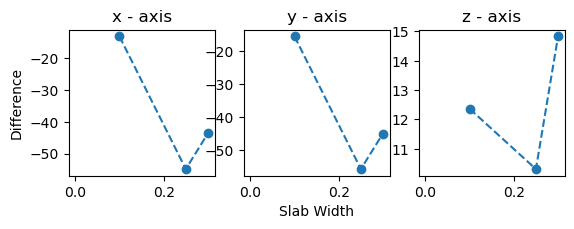

In [7]:
fig, axs = plt.subplots(1, 3)

axis = {0 : 'x', 1 : 'y' , 2 : 'z'}
for i in range(3):
    ax = axs[i]
    ax.plot(x, y[:][i], '--o')
    ax.set_title(f'{axis[i]} - axis')
    ax.set_box_aspect(aspect=1)
    ax.axvline(0, color='black', linewidth=0)

axs[0].set_ylabel('Difference')
axs[1].set_xlabel('Slab Width')



plt.show()

Density profile obtained from individual slabs

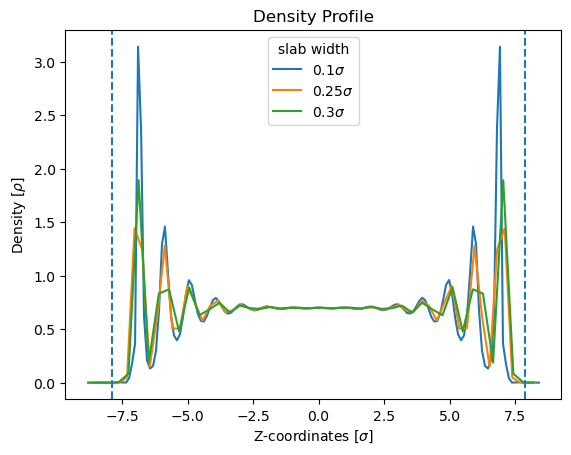

In [8]:

for key in file_dict:
    y = observable_dict[key]['slab_density']
    x = np.linspace(-8.5, 8.5 , y.shape[0]) - file_dict[key]

    plt.plot(x,y, label = f'{file_dict[key]}$\sigma$')
    

plt.axvline(-7.88, ls = '--')
plt.axvline(7.88, ls = '--')

plt.title("Density Profile")
plt.xlabel(r'Z-coordinates $[\sigma]$')
plt.ylabel(r"Density $[\rho]$")


plt.legend(title = 'slab width')
plt.show()


Following calculations are done on simulation with slabs of 0.1sigma width

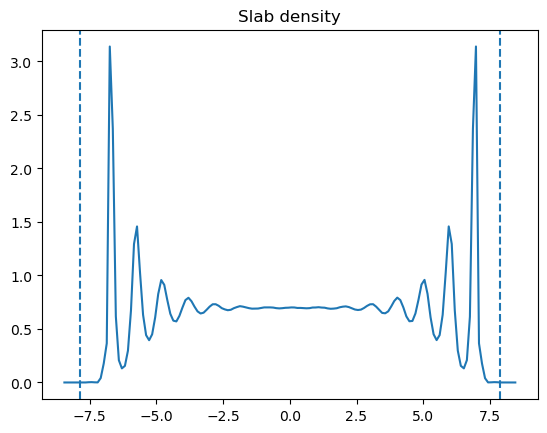

In [9]:

y = observable_dict['slit_01s.h5']['slab_density']
x = np.linspace(-8.5 + file_dict['slit_01s.h5']/2, 8.5 - file_dict['slit_01s.h5']/2, y.shape[0])

plt.axvline(-7.88, ls = '--')
plt.axvline(7.88, ls = '--')

plt.title("Slab density")

plt.plot(x,y)


Stress tensor anisotropy, difference of x and y components of stress tensor along the slabs 

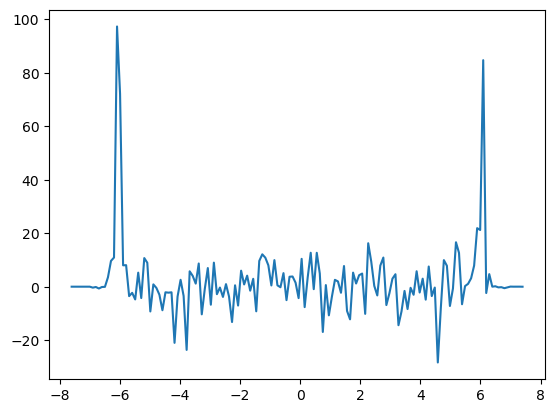

In [10]:

y = observable_dict["slit_01s.h5"]["slab_stress_tensor"][:,0] - observable_dict["slit_01s.h5"]["slab_stress_tensor"][:,1]
x = np.linspace(-15/2, 15/2, y.shape[0]) - file_dict['slit_01s.h5']

plt.plot(x, y)

non-normalized local surface density

$$ \gamma^* = \sigma_\parallel - \sigma_\perp  $$
$$ \gamma^* = \frac{1}{2} (\sigma_{xx} + \sigma_{yy}) - \sigma_{zz} 

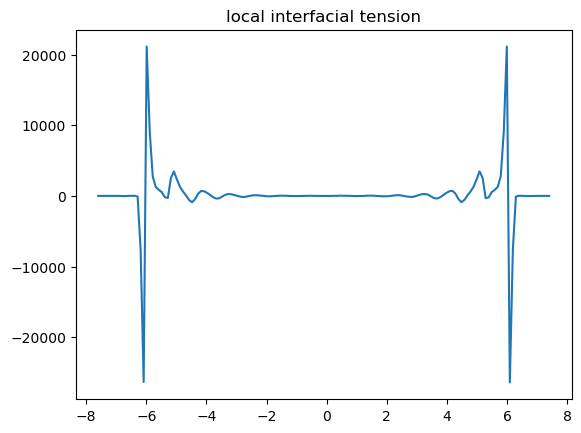

In [11]:
s = []
for i in range(3):
    s.append(observable_dict["slit_01s.h5"]["slab_stress_tensor"][:,i])

lst = 0.5*(s[0] + s[1]) - s[2]

plt.title("local interfacial tension")
plt.plot(x, lst)

normalized stress tensor = stress tensor / volume

$$ P = \frac {\sigma}{Area * \Delta z } $$

Surface tension  $$ \gamma =  \int _{-\infty}^{\infty}  [P_{\perp}(z) - P_{\parallel}(z)] dz$$

in finite slices:
$$ \gamma =  \sum _{i = 0}^{N}  [P_{\perp}(z)_i - P_{\parallel}(z)_i] \Delta z_i$$


$$ \gamma =   \sum _{i = 0}^{N}  [\frac {\sigma_{\perp} (z)_i}{Area * \Delta z_i} - \frac {\sigma_{\parallel} (z)_i}{Area * \Delta z_i}] \Delta z_i$$

The equation simplifies to:

$$ \gamma =  \frac{1}{Area} \sum _{i = 0}^{N}  [ {\sigma_{\perp} (z)_i} -  {\sigma_{\parallel} (z)_i}]$$

In [12]:
area = 100*100
surface_tension = 0.5 * np.sum(lst)/area
print(f'surface tension per interface: {surface_tension:.3f}') 

surface tension per interface: 1.137


In [4]:
def read_wavevectors(file_name):

    file_path = f'{data_folder}/{file_name}'

    with h5py.File(file_path, 'r') as sim_data:

        # Read wavevectors
        wavenumber_slab_parallel = np.array(sim_data['ssf/slab_1/parallel/wavenumber']).tolist()
        wavenumber_slab_perpendicular = np.array(sim_data['ssf/slab_1/perpendicular/wavenumber']).tolist()

        wavenumber_global_parallel = np.array(sim_data['ssf/global_parallel/wavenumber']).tolist()
        wavenumber_global_perpendicular = np.array(sim_data['ssf/global_perpendicular/wavenumber']).tolist()

    return [wavenumber_slab_parallel, wavenumber_slab_perpendicular], [wavenumber_global_parallel, wavenumber_global_perpendicular]



def read_ssf(file_name):

    file_path = f'{data_folder}/{file_name}'
    num_regions = 0

    wavenumber_slab, wavenumber_global = read_wavevectors(file_name)


    with h5py.File(file_path, 'r') as sim_data:
        region_list = list(sim_data['ssf'].keys())
        num_regions = len(region_list)


        # Calculate time averaged static structure factor
        ssf_parallel = np.zeros((num_regions, len(wavenumber_slab[0]), 3))
        ssf_perpendicular = np.zeros((num_regions, len(wavenumber_slab[1]), 3))

        for i in range(1, num_regions - 1):
            dataset_parallel_path = f'ssf/slab_{i}/parallel/value'
            dataset_perpendicular_path = f'ssf/slab_{i}/perpendicular/value'

            ssf_parallel_cur = np.array(sim_data[dataset_parallel_path])
            ssf_perpendicular_cur = np.array(sim_data[dataset_perpendicular_path])

            ssf_parallel[i] = np.average(ssf_parallel_cur, axis = 0)
            ssf_perpendicular[i] = np.average(ssf_perpendicular_cur, axis = 0)



        # Calculate time averaged static structure along simulation box
        ssf_parallel_global = np.zeros((len(wavenumber_global[0]), 3))
        ssf_perpendicular_global = np.zeros((len(wavenumber_global[1]), 3))

        dataset_path = f'ssf/global_parallel/value'
        dataset = sim_data[dataset_path]
        ssf_parallel_global = np.average(np.array(dataset), axis = 0)

        dataset_path = f'ssf/global_perpendicular/value'
        dataset = sim_data[dataset_path]
        ssf_perpendicular_global = np.average(np.array(dataset), axis = 0)
        

        return ssf_parallel, ssf_perpendicular, ssf_parallel_global, ssf_perpendicular_global
    


In [12]:
ssf_parallel, ssf_perpendicular, ssf_parallel_global, ssf_perpendicular_global = read_ssf("slit_1s_NVE_amorphous_2.h5")
wavenumber_slab, wavenumber_global = read_wavevectors("slit_1s_NVE_amorphous_2.h5")

In [13]:
ssf_parallel_global.shape

(477, 3)

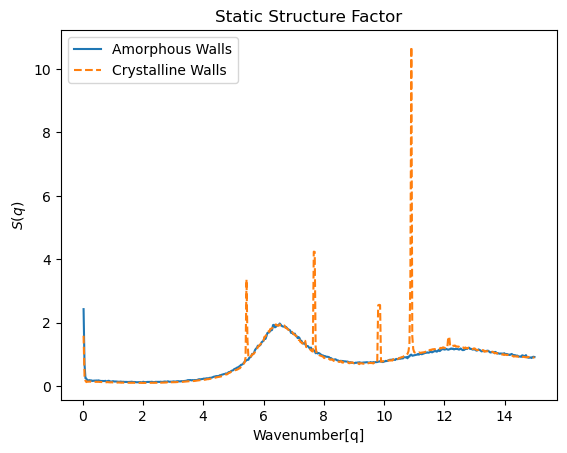

In [17]:
ssf_parallel, ssf_perpendicular, ssf_parallel_global, ssf_perpendicular_global = read_ssf("slit_1s_NVE_amorphous_2.h5")
wavenumber_slab, wavenumber_global = read_wavevectors("slit_1s_NVE_amorphous_2.h5")

x = wavenumber_global[0]
y = ssf_parallel_global[:, 0]


plt.plot(x, y, label = "Amorphous Walls")

ssf_parallel, ssf_perpendicular, ssf_parallel_global, ssf_perpendicular_global = read_ssf("slit_1s_NVE_cutoff35.h5")
wavenumber_slab, wavenumber_global = read_wavevectors("slit_1s_NVE_cutoff35.h5")

x = wavenumber_global[0]
y = ssf_parallel_global[:, 0]


plt.plot(x, y, ls = '--', label = "Crystalline Walls")


plt.title("Static Structure Factor")
plt.ylabel(r"$S(q)$")
plt.xlabel(r"Wavenumber[q]")
#plt.xscale("log")
plt.legend()
plt.show()

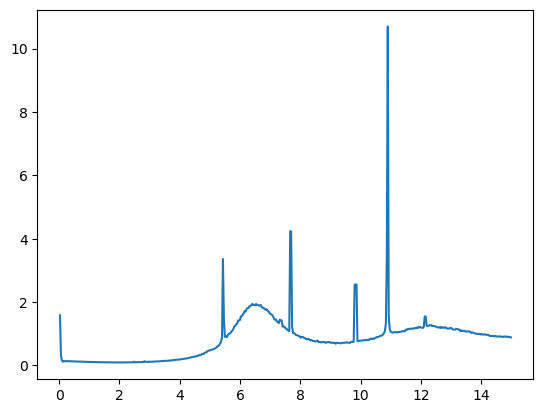

In [15]:
ssf_parallel, ssf_perpendicular, ssf_parallel_global, ssf_perpendicular_global = read_ssf("slit_1s_NVE_cutoff35.h5")
wavenumber_slab, wavenumber_global = read_wavevectors("slit_1s_NVE_cutoff35.h5")

x = wavenumber_global[0]
y = ssf_parallel_global[:, 0]


plt.plot(x, y, label = "Amorphous Walls")

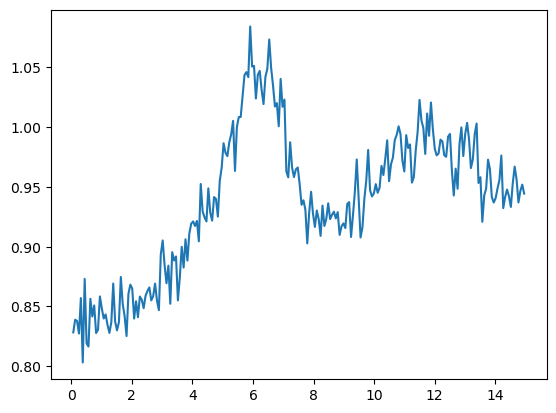

In [16]:
x = wavenumber_slab[0]
y = ssf_parallel[75,:,0] #middle slab

#plt.xscale('log')
plt.plot(x, y)

In [ ]:
ssf_parallel, ssf_perpendicular, ssf_parallel_global, ssf_perpendicular_global = read_ssf("slit_01s.h5")
wavenumber_slab, wavenumber_global = read_wavevectors("slit_01s.h5")

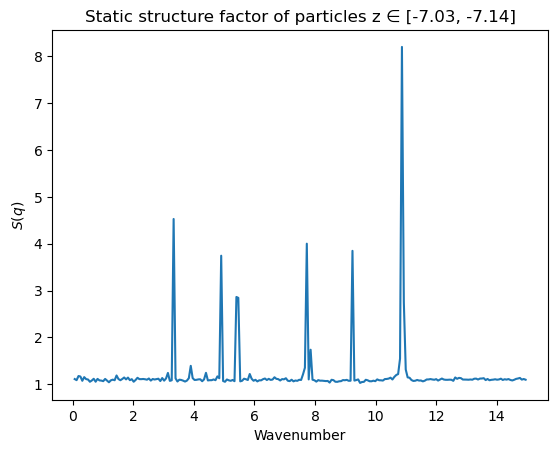

In [8]:
x = wavenumber_slab[0]
y = ssf_parallel[12,:,0] #interface region


plt.plot(x, y)


plt.title("Static structure factor of particles z ∈ [-7.03, -7.14]")
plt.ylabel(r"$S(q)$")
plt.xlabel(r"Wavenumber")
#plt.xscale("log")
plt.show()

In [64]:
file_path = f'{data_folder}/{"slit_01s.h5"}'
num_regions = 0

temperature = []

with h5py.File(file_path, 'r') as sim_data:
    region_list = list(sim_data['thermo'].keys())
    num_regions = len(region_list)

    for i in range(1, num_regions - 1):
        db_path = f'thermo/slab_{i}/temperature/value'
        temperature.append(np.average(sim_data[db_path], axis=0))


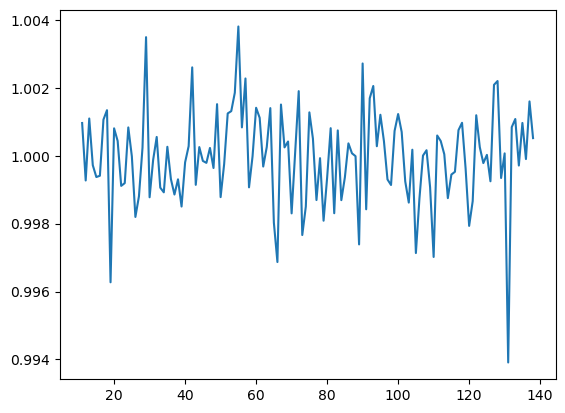

In [65]:
plt.plot(temperature)

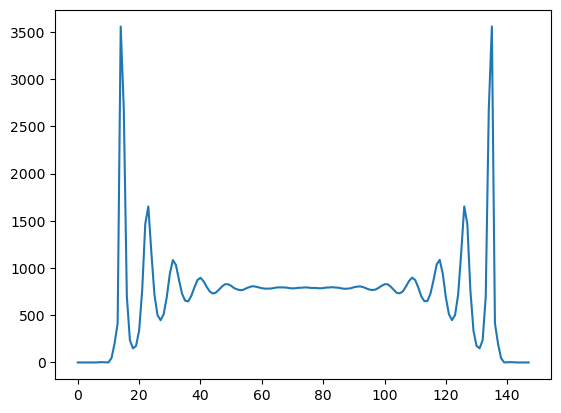

In [36]:
plt.plot(particle_num_list)

In [ ]:


file_path = f'{data_folder}/{"slit_01s.h5"}'
num_regions = 0

particle_num_list = []

with h5py.File(file_path, 'r') as sim_data:
    region_list = list(sim_data['thermo'].keys())
    num_regions = len(region_list)

    for i in range(1, num_regions - 1):
        db_path = f'thermo/slab_{i}/particle_number/value'
        particle_num_list.append(np.average(sim_data[db_path], axis=0))


In [37]:
particle_num_list[12]

201.00399201596807

In [38]:
np.sum(particle_num_list)

104998.27145708582

In [9]:
"[17-08-2025 18:32:34.306328] region (region-z13): lowest corner: -50 -50 -7.14"
"[17-08-2025 18:32:34.306336] region (region-z13): edge length: 100 100 0.113333"


with h5py.File(f'{data_folder}/{"slit_01s.h5"}', 'r') as f:
    pos_fluid = f['/particles/fluid/position/value'][0]
    pos_obst = f['/particles/obstacles/position/value'][0]



species_fluid = ['F'] * pos_fluid.shape[0]
species_obst = ['O'] * pos_obst.shape[0]


all_positions = np.vstack((pos_fluid, pos_obst))
all_species = species_fluid + species_obst
n_atoms = all_positions.shape[0]

pos_list = np.empty(3)

for atom, pos in zip(all_species, all_positions):
    if atom == "F" and pos[2] > -7.14  and pos[2] < -7.02667:
        pos_list = np.vstack((pos_list, pos))



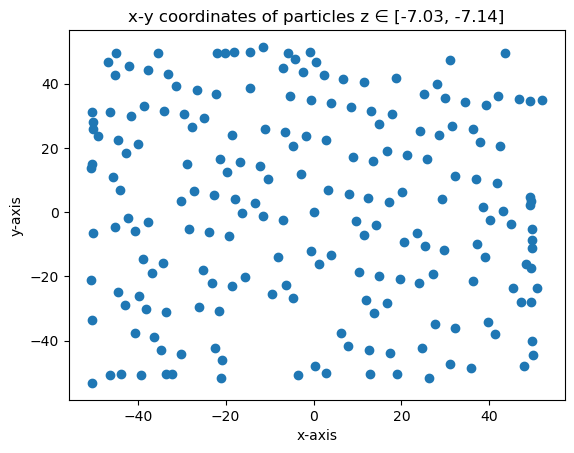

In [ ]:
plt.scatter(pos_list[:,0], pos_list[:,1])

plt.xlabel("x-axis")
plt.ylabel("y-axis")


plt.title("x-y coordinates of particles z ∈ [-7.03, -7.14]")

plt.show()

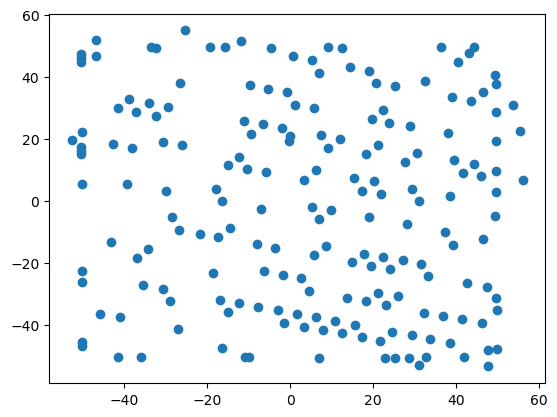

In [44]:
plt.scatter(pos_list[:,0], pos_list[:,1])

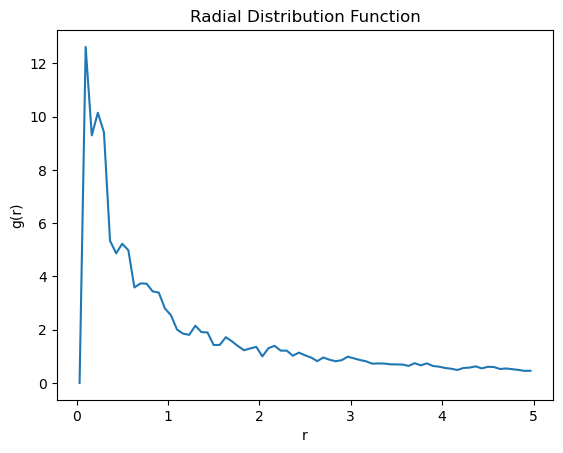

In [46]:
def radial_distribution_function(positions, r_max=None, bins=100, box=None):

    N = len(positions)
    
    # Compute all pairwise distances
    diff = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]
    
    # Apply periodic boundary conditions (minimum image convention)
    if box is not None:
        box = np.asarray(box)
        diff -= box * np.round(diff / box)
    
    dist = np.linalg.norm(diff, axis=-1)
    
    # Take upper triangle only (unique pairs, no self-distances)
    i, j = np.triu_indices(N, k=1)
    dist = dist[i, j]
    
    # Set cutoff if not provided
    if r_max is None:
        if box is not None:
            r_max = min(box) / 2.0
        else:
            r_max = dist.max()
    
    # Histogram distances
    hist, edges = np.histogram(dist, bins=bins, range=(0, r_max))
    r = 0.5 * (edges[1:] + edges[:-1])  # bin centers
    
    # Normalization
    rho = N / (box[0] * box[1] * box[2]) if box is not None else N / (4/3 * np.pi * r_max**3)
    shell_vol = 4/3 * np.pi * (edges[1:]**3 - edges[:-1]**3)
    ideal = rho * shell_vol * N
    
    g_r = hist / ideal
    
    return r, g_r

# Example usage:
positions = np.random.rand(200, 3) * 10.0  # 200 particles in a 10x10x10 cube
r, g_r = radial_distribution_function(pos_list, bins=75, box=[10,10,10])

plt.plot(r, g_r)
plt.xlabel("r")
plt.ylabel("g(r)")
plt.title("Radial Distribution Function")
plt.show()


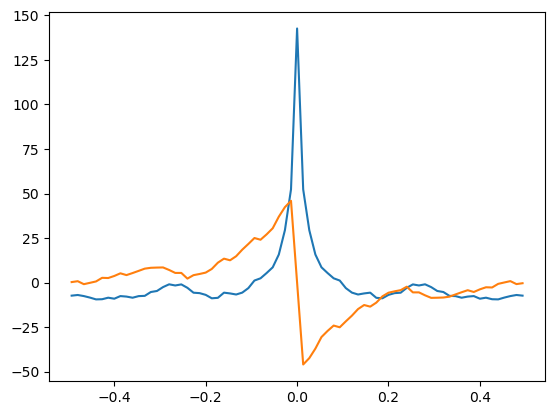

In [51]:


from scipy.fft import fft, fftfreq, fftshift
import matplotlib.pyplot as plt
t = np.arange(g_r.shape[0])
sp = fftshift(fft(g_r))
freq = fftshift(fftfreq(t.shape[-1]))
plt.plot(freq, sp.real, freq, sp.imag)

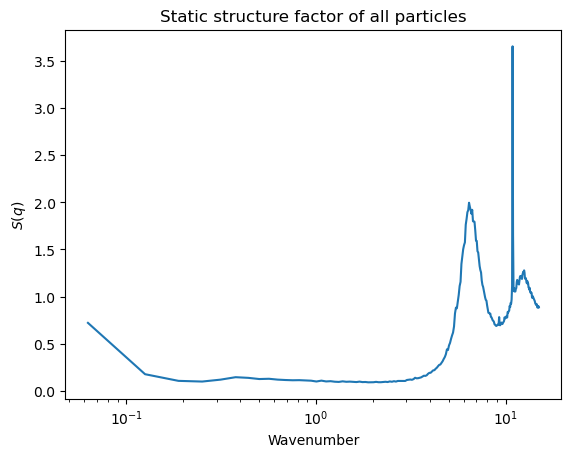

In [19]:
plt.plot(wavenumber_global[0], ssf_parallel_global[:,0])

plt.title("Static structure factor of all particles")
plt.ylabel(r"$S(q)$")
plt.xlabel(r"Wavenumber")
plt.xscale("log")
plt.show()

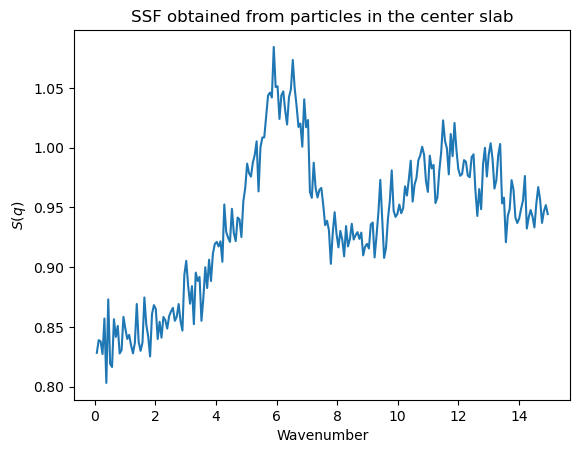

In [37]:
x = wavenumber_slab[0]
y = ssf_parallel[75,:,0] #middle slab

plt.title("SSF obtained from particles in the center slab")
plt.ylabel(r"$S(q)$")
plt.xlabel(r"Wavenumber")


#plt.xscale('log')
plt.plot(x, y)
plt.show()

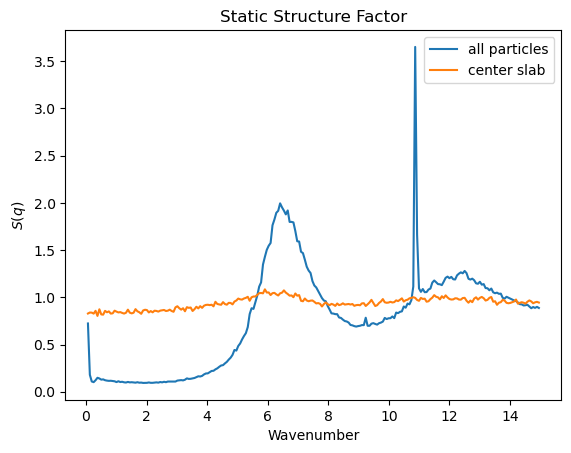

In [42]:
plt.plot(wavenumber_global[0], ssf_parallel_global[:,0], label = "all particles")

x = wavenumber_slab[0]
y = ssf_parallel[75,:,0] #middle slab

plt.plot(x, y, label = "center slab")

plt.title("Static Structure Factor")
plt.ylabel(r"$S(q)$")
plt.xlabel(r"Wavenumber")
#plt.xscale("log")
plt.legend()
plt.show()

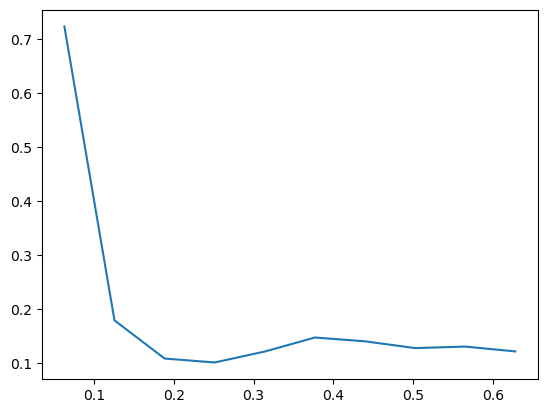

In [18]:
plt.plot(wavenumber_global[0][:10], ssf_parallel_global[:10,0])
#plt.xscale("log")
plt.show()

In [19]:
def lorentzian(q, s0, xi):

    return s0 / (1 + (q * xi)**2)

In [20]:
x = np.array(wavenumber_global[0][5:30])
y = ssf_parallel_global[5:30,0]


In [21]:
from scipy.optimize import curve_fit

popt, pcov = curve_fit(lorentzian, x, y)


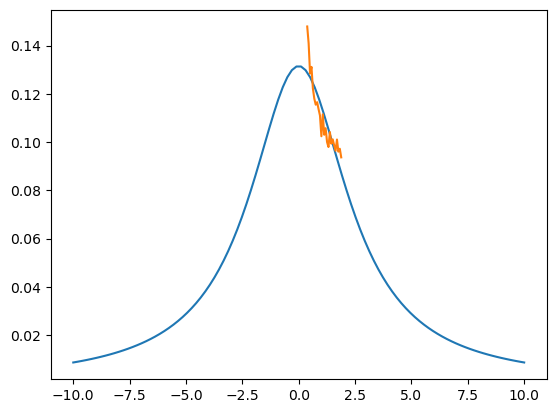

In [22]:
xx = np.linspace(-10, 10, 100)
plt.plot(xx, lorentzian(xx, popt[0], popt[1]))
plt.plot(x, y)


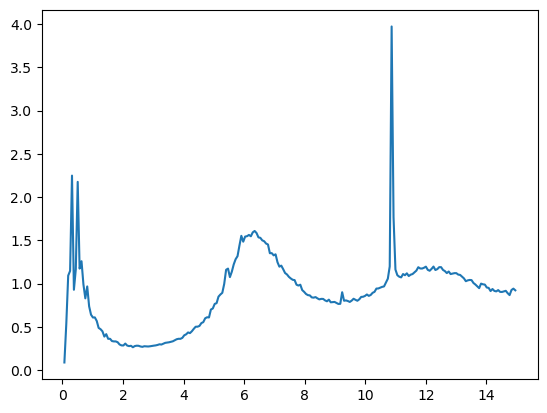

In [23]:
ssf_parallel, ssf_perpendicular, ssf_parallel_global, ssf_perpendicular_global = read_ssf("slit_025_lp.h5")
wavenumber_slab, wavenumber_global = read_wavevectors("slit_025_lp.h5")

plt.plot(wavenumber_global[0], ssf_parallel_global[:,0])
#plt.xscale("log")
plt.show()

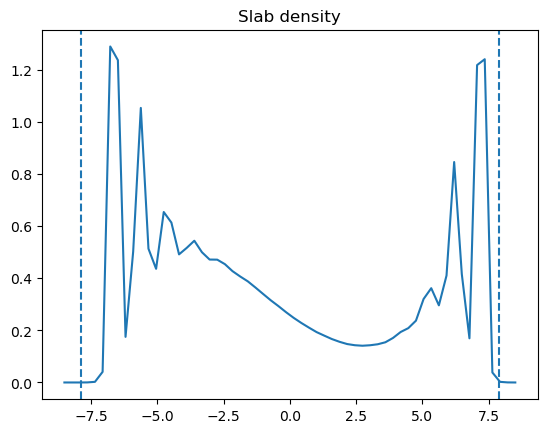

In [24]:
obs = sample_observables("slit_025_lp.h5")

y = obs['slab_density']
x = np.linspace(-8.5, 8.5, y.shape[0])

plt.axvline(-7.88, ls = '--')
plt.axvline(7.88, ls = '--')

plt.title("Slab density")

plt.plot(x,y)


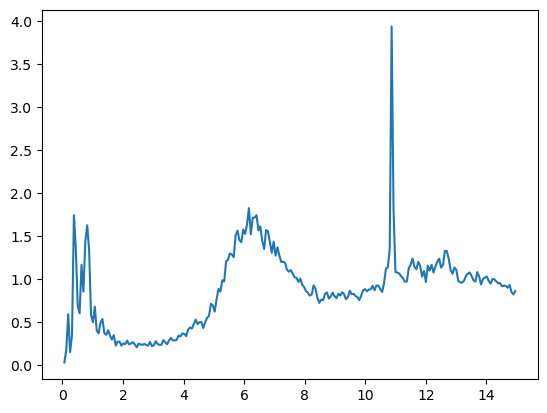

In [25]:
ssf_parallel, ssf_perpendicular, ssf_parallel_global, ssf_perpendicular_global = read_ssf("slit_025_lp2.h5")
wavenumber_slab, wavenumber_global = read_wavevectors("slit_025_lp2.h5")

plt.plot(wavenumber_global[0], ssf_parallel_global[:,0])
#plt.xscale("log")
plt.show()

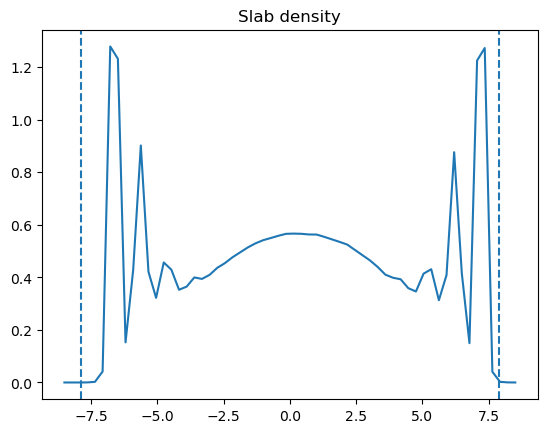

In [26]:
obs = sample_observables("slit_025_lp2.h5")

y = obs['slab_density']
x = np.linspace(-8.5, 8.5, y.shape[0])

plt.axvline(-7.88, ls = '--')
plt.axvline(7.88, ls = '--')

plt.title("Slab density")

plt.plot(x,y)


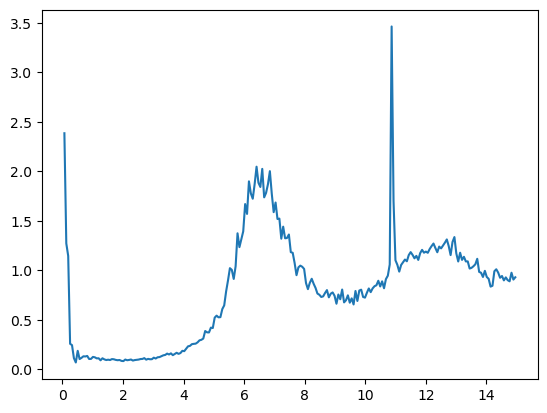

In [27]:
ssf_parallel, ssf_perpendicular, ssf_parallel_global, ssf_perpendicular_global = read_ssf("slit_025_lp3.h5")
wavenumber_slab, wavenumber_global = read_wavevectors("slit_025_lp3.h5")

plt.plot(wavenumber_global[0], ssf_parallel_global[:,0])
#plt.xscale("log")
plt.show()

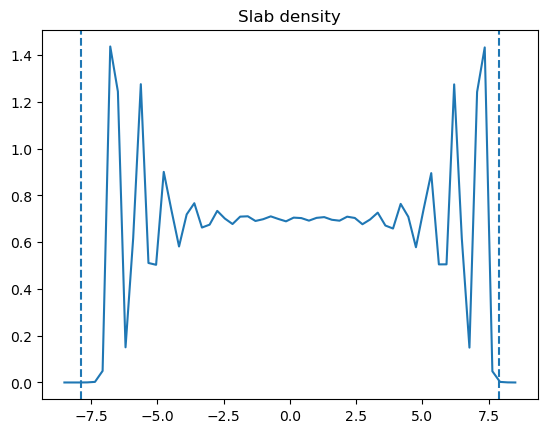

In [28]:
obs = sample_observables("slit_025_lp3.h5")

y = obs['slab_density']
x = np.linspace(-8.5, 8.5, y.shape[0])

plt.axvline(-7.88, ls = '--')
plt.axvline(7.88, ls = '--')

plt.title("Slab density")

plt.plot(x,y)


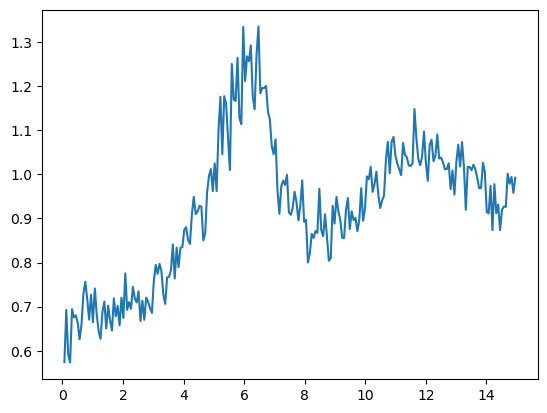

In [29]:
x = wavenumber_slab[0]
y = ssf_parallel[30,:,0] #middle slab

#plt.xscale('log')
plt.plot(x, y)

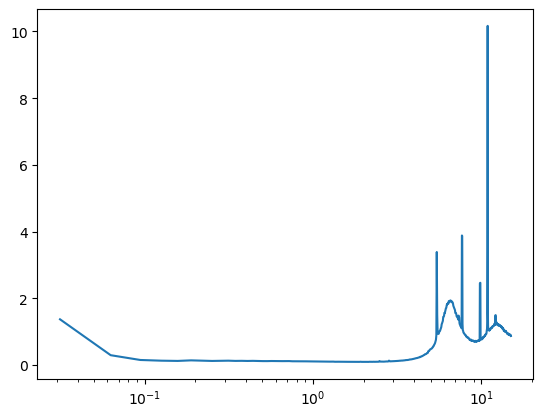

In [32]:
ssf_parallel, ssf_perpendicular, ssf_parallel_global, ssf_perpendicular_global = read_ssf("slit_1s_NVE.h5")
wavenumber_slab, wavenumber_global = read_wavevectors("slit_1s_NVE.h5")

plt.plot(wavenumber_global[0], ssf_parallel_global[:,0])
plt.xscale("log")
plt.show()

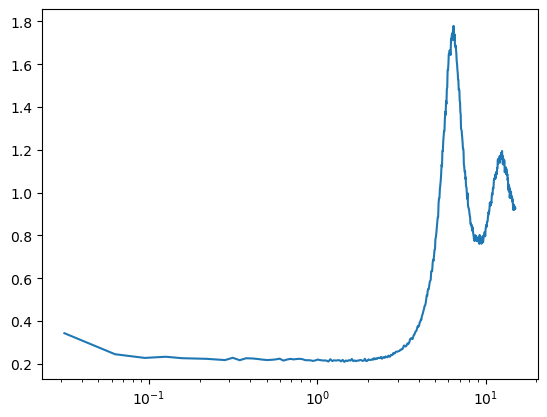

In [34]:
x = wavenumber_slab[0]
y = ssf_parallel[6,:,0] #middle slab

plt.xscale('log')
plt.plot(x, y)

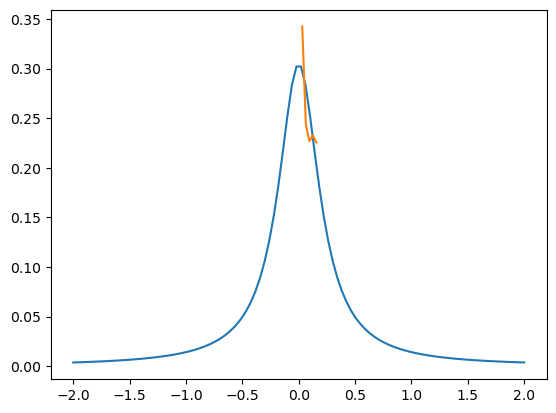

In [38]:
from scipy.optimize import curve_fit

x = x[:10]
y = y[:10]

popt, pcov = curve_fit(lorentzian, x, y)

xx = np.linspace(-2, 2, 100)
plt.plot(xx, lorentzian(xx, popt[0], popt[1]))
plt.plot(x, y)


In [31]:
obs = sample_observables("slit_1s.h5")

y = obs['slab_density']
x = np.linspace(-8.5, 8.5, y.shape[0])

plt.axvline(-7.88, ls = '--')
plt.axvline(7.88, ls = '--')

plt.title("Slab density")

plt.plot(x,y)


BlockingIOError: [Errno 11] Unable to open file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')

In [ ]:



slit_1s_NVE.h5

In [43]:
ssf_parallel_NVE, ssf_perpendicular_NVE, ssf_parallel_global_NVE, ssf_perpendicular_global_NVE = read_ssf("slit_1s_NVE.h5")
wavenumber_slab_NVE, wavenumber_global_NVE = read_wavevectors("slit_1s_NVE.h5")


ssf_parallel_NVT, ssf_perpendicular_NVT, ssf_parallel_global_NVT, ssf_perpendicular_global_NVT = read_ssf("slit_1s.h5")
wavenumber_slab_NVT, wavenumber_global_NVT = read_wavevectors("slit_1s.h5")


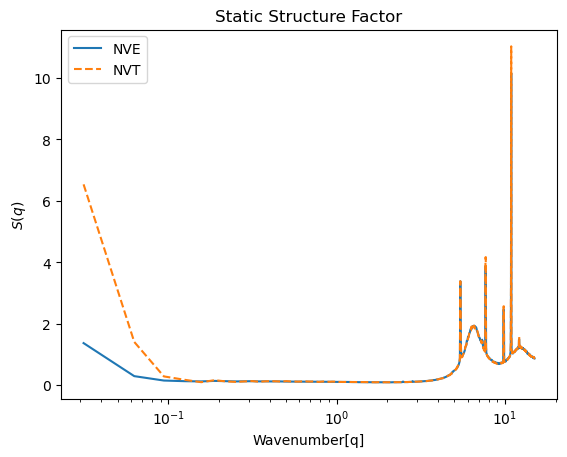

In [47]:
plt.plot(wavenumber_global_NVE[0], ssf_parallel_global_NVE[:,0], label = "NVE")

plt.plot(wavenumber_global_NVT[0], ssf_parallel_global_NVT[:,0], label = "NVT", ls = '--')

plt.title("Static Structure Factor")
plt.ylabel(r"$S(q)$")
plt.xlabel(r"Wavenumber[q]")
plt.xscale("log")
plt.legend()
plt.show()

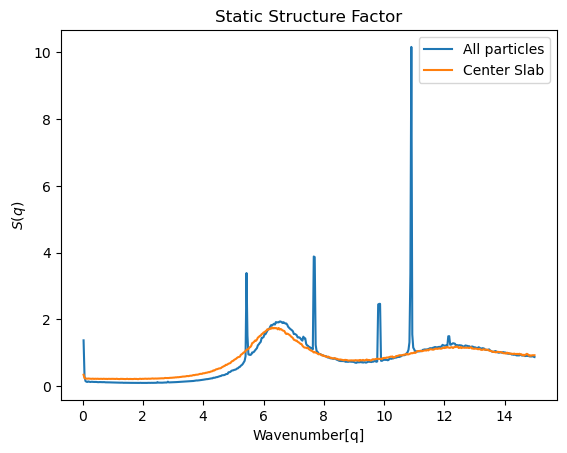

In [51]:
plt.plot(wavenumber_global_NVE[0], ssf_parallel_global_NVE[:,0], label = "All particles")

x = wavenumber_slab_NVE[0]
y = ssf_parallel_NVE[7,:,0] #middle slab

plt.plot(x, y, label = 'Center Slab')

plt.title("Static Structure Factor")
plt.ylabel(r"$S(q)$")
plt.xlabel(r"Wavenumber[q]")
#plt.xscale("log")
plt.legend()
plt.show()